ETS-ANN hybrid model for Bitcoin Python 3.9.18

In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from pycaret.utils import version
version()
from pycaret.time_series import TSForecastingExperiment
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima.arima.utils import nsdiffs, ndiffs
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.seasonal import STL
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pycaret.time_series import *



Data pre-processing

1. Step given time series y

In [170]:
df_BTC = yf.download(
tickers = ["BTC-USD"],
start = "2020-01-01",
end = "2025-01-02"
)

df_BTC.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df_BTC.shape
df_BTC.info()
print('Null Values:',df_BTC.isnull().values.sum())
print(df_BTC.columns)
df_BTC.reset_index(inplace=True)
df_BTC['Date'] = pd.to_datetime(df_BTC['Date'], format='%Y-%m-%d')
df_BTC = df_BTC[['Date', 'Close']]
df_BTC.head()
df_BTC.set_index('Date', inplace=True)
print(df_BTC.index)
df_BTC = df_BTC.asfreq('D')  
print(f"Frequency of the index: {df_BTC.index.freq}")


[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1828 entries, 2020-01-01 to 2025-01-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1828 non-null   float64
 1   High    1828 non-null   float64
 2   Low     1828 non-null   float64
 3   Open    1828 non-null   float64
 4   Volume  1828 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 85.7 KB
Null Values: 0
Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')
DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2024-12-23', '2024-12-24', '2024-12-25', '2024-12-26',
               '2024-12-27', '2024-12-28', '2024-12-29', '2024-12-30',
               '2024-12-31', '2025-01-01'],
              dtype='datetime64[ns]', name='Date', length=1828, freq=None)
Frequency of the ind

Setting up the Time Series Experiment for our data

In [171]:

exp_btc = TSForecastingExperiment()
exp_btc.setup(data=df_BTC, target='Close', fh=365, session_id=123,coverage=0.90)
exp_btc.check_stats()


,Description,Value
0,session_id,123
1,Target,Close
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(1828, 1)"
5,Transformed data shape,"(1828, 1)"
6,Transformed train set shape,"(1463, 1)"
7,Transformed test set shape,"(365, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,1828.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,36349.146233
3,Summary,Statistics,Transformed,Median,,32237.828125
4,Summary,Statistics,Transformed,Standard Deviation,,21157.704344
5,Summary,Statistics,Transformed,Variance,,447648453.129209
6,Summary,Statistics,Transformed,Kurtosis,,0.034563
7,Summary,Statistics,Transformed,Skewness,,0.67212
8,Summary,Statistics,Transformed,# Distinct Values,,1828.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",39154.349847


2. Split of the data into train test 

In [172]:
complete_data = exp_btc.get_config('y')  

fh = exp_btc.get_config('fh')  
train_data_btc = complete_data[:-fh[0]]  
test_data_btc = complete_data[-fh[0]:]  

y_train_btc = exp_btc.get_config('y_train')
y_test_btc = exp_btc.get_config('y_test')

print("Training Data:")
print(y_train_btc)

print("\nTesting Data:")
print(y_test_btc)

Training Data:
Date
2020-01-01     7200.174316
2020-01-02     6985.470215
2020-01-03     7344.884277
2020-01-04     7410.656738
2020-01-05     7411.317383
                  ...     
2023-12-29    42099.402344
2023-12-30    42156.902344
2023-12-31    42265.187500
2024-01-01    44167.332031
2024-01-02    44957.968750
Freq: D, Name: Close, Length: 1463, dtype: float64

Testing Data:
Date
2024-01-03    42848.175781
2024-01-04    44179.921875
2024-01-05    44162.691406
2024-01-06    43989.195312
2024-01-07    43943.097656
                  ...     
2024-12-28    95163.929688
2024-12-29    93530.226562
2024-12-30    92643.210938
2024-12-31    93429.203125
2025-01-01    94419.757812
Freq: D, Name: Close, Length: 365, dtype: float64


Available models for the experiment

In [173]:
exp_btc.models()

,Name,Reference,Turbo
ID,,,
naive,Naive Forecaster,sktime.forecasting.naive.NaiveForecaster,True
grand_means,Grand Means Forecaster,sktime.forecasting.naive.NaiveForecaster,True
snaive,Seasonal Naive Forecaster,sktime.forecasting.naive.NaiveForecaster,True
polytrend,Polynomial Trend Forecaster,sktime.forecasting.trend._polynomial_trend_for...,True
arima,ARIMA,sktime.forecasting.arima.ARIMA,True
auto_arima,Auto ARIMA,sktime.forecasting.arima.AutoARIMA,True
exp_smooth,Exponential Smoothing,sktime.forecasting.exp_smoothing.ExponentialSm...,True
croston,Croston,sktime.forecasting.croston.Croston,True
ets,ETS,sktime.forecasting.ets.AutoETS,True


ETS model selection for the data

4. Determine the best ETS (E,T,S) using in-sample data (which is misnamed to be "trainin)

In [174]:
ses_btc = exp_btc.create_model('exp_smooth', trend=None, seasonal=None, sp= None, cross_validation=False )
ht_btc = exp_btc.create_model('exp_smooth', trend='add', seasonal=None, cross_validation=False)
#
hw_add_btc = exp_btc.create_model('exp_smooth', trend='add', seasonal='add', sp= 365, cross_validation=False)
hw_mult_btc = exp_btc.create_model('exp_smooth', trend='add', seasonal='mul', sp=365, cross_validation=False)
hw_damped_btc = exp_btc.create_model('exp_smooth', damped_trend='True' , trend='add', seasonal='mul', sp=365, cross_validation=False)
#
ets_ANN_btc = exp_btc.create_model('ets', error="add", trend=None, seasonal=None ,cross_validation=False ) # this is equivalent 
ets_AAN_btc = exp_btc.create_model('ets', error="add", trend="add", seasonal=None ,cross_validation=False ) # this is 
ets_AAM_btc = exp_btc.create_model('ets', error="add", trend="add", seasonal="mul" ,cross_validation=False )
#
naive_btc = exp_btc.create_model('naive', cross_validation=False)
snaive_btc = exp_btc.create_model('snaive', cross_validation=False)



,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,9.4896,7.3719,21668.6224,25803.5342,0.2991,0.3656,-2.0932


,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,4.7717,4.0575,10895.8486,14202.1808,0.1744,0.1551,0.0630


,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,4.6148,4.1232,10537.6225,14432.3696,0.1422,0.1590,0.0323


,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,5.3625,4.6335,12244.9235,16218.6319,0.1695,0.1906,-0.2220


,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,9.7308,7.8072,22219.3860,27327.4158,0.3084,0.3864,-2.4693


,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,9.4896,7.3719,21668.6406,25803.5524,0.2991,0.3656,-2.0932


,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,5.7458,4.8475,13120.1146,16967.7004,0.1778,0.2027,-0.3375


,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,6.5095,5.3444,14863.9178,18706.6654,0.2023,0.2335,-0.6257


,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,9.4805,7.3660,21647.8404,25782.8075,0.2988,0.3652,-2.0882


,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,10.1757,7.8131,23235.4526,27347.7817,0.3218,0.3995,-2.4745


In [175]:
exp_btc.compare_models(include=[ ses_btc, ht_btc, hw_add_btc, hw_mult_btc, hw_damped_btc, ets_ANN_btc, ets_AAN_btc, ets_AAM_btc, naive_btc, snaive_btc, 'ets'], cross_validation=False)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
2,Exponential Smoothing,4.6148,4.1232,10537.6225,14432.3696,0.1422,0.1590,0.0323,0.2800
1,Exponential Smoothing,4.7717,4.0575,10895.8486,14202.1808,0.1744,0.1551,0.0630,0.0300
3,Exponential Smoothing,5.3625,4.6335,12244.9235,16218.6319,0.1695,0.1906,-0.2220,0.7000
6,ETS,5.7458,4.8475,13120.1146,16967.7004,0.1778,0.2027,-0.3375,0.0200
7,ETS,6.5095,5.3444,14863.9178,18706.6654,0.2023,0.2335,-0.6257,0.0700
10,ETS,6.5095,5.3444,14863.9178,18706.6654,0.2023,0.2335,-0.6257,0.0800
8,Naive Forecaster,9.4805,7.3660,21647.8404,25782.8075,0.2988,0.3652,-2.0882,0.0100
0,Exponential Smoothing,9.4896,7.3719,21668.6224,25803.5342,0.2991,0.3656,-2.0932,0.0100
5,ETS,9.4896,7.3719,21668.6406,25803.5524,0.2991,0.3656,-2.0932,0.0100
4,Exponential Smoothing,9.7308,7.8072,22219.3860,27327.4158,0.3084,0.3864,-2.4693,0.8300


ExponentialSmoothing(seasonal='add', sp=365, trend='add')

In [176]:

ets_auto_btc = exp_btc.create_model('ets', cross_validation=False)  # Auto ETS selection
tuned_ets_auto_btc = exp_btc.tune_model(ets_auto_btc)

,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,6.5095,5.3444,14863.9178,18706.6654,0.2023,0.2335,-0.6257


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,"PeriodIndex(['2021-01-02'], dtype='period[D]', name='Date')",10.2273,8.3774,9689.9582,12398.5944,0.1867,0.2127,-0.6355
1,"PeriodIndex(['2022-01-02'], dtype='period[D]', name='Date')",6.9579,5.1351,19011.0089,21452.1070,0.8970,0.5507,-3.4953
2,"PeriodIndex(['2023-01-02'], dtype='period[D]', name='Date')",8.5143,6.2638,21619.3989,24106.8895,0.7053,1.1828,-15.4970
Mean,nan,8.5665,6.5921,16773.4553,19319.1969,0.5963,0.6487,-6.5426
SD,nan,1.3352,1.3438,5120.7339,5012.1866,0.3001,0.4021,6.4384


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.7s finished


In [177]:
exp_btc.compare_models(include=[ hw_add_btc, tuned_ets_auto_btc], cross_validation=False) # Compare tuned Auto-ETS 

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
0,Exponential Smoothing,4.6148,4.1232,10537.6225,14432.3696,0.1422,0.1590,0.0323,0.2900
1,ETS,5.0301,4.3720,11485.7604,15303.1419,0.1552,0.1748,-0.0879,0.0800


ExponentialSmoothing(seasonal='add', sp=365, trend='add')

For our data hw_add_btc is the best model

In [178]:
# Debugging: Check the type and attributes of hw_add_btc
print(f"Type of hw_add_btc: {type(hw_add_btc)}")
print(f"Attributes and methods of hw_add_btc: {dir(hw_add_btc)}")

Type of hw_add_btc: <class 'sktime.forecasting.exp_smoothing.ExponentialSmoothing'>
Attributes and methods of hw_add_btc: ['_X', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__mul__', '__ne__', '__new__', '__or__', '__reduce__', '__reduce_ex__', '__repr__', '__rmul__', '__rpow__', '__setattr__', '__sizeof__', '__slotnames__', '__str__', '__subclasshook__', '__weakref__', '_alias_params', '_check_X', '_check_X_y', '_check_fh', '_clone_flags', '_components', '_config', '_config_doc', '_config_dynamic', '_converter_store_y', '_cutoff', '_extract_conf_int', '_fh', '_fit', '_fit_forecaster', '_fitted_forecaster', '_fitted_param_names', '_forecaster', '_get_class_flag', '_get_class_flags', '_get_columns', '_get_fitted_param_names', '_get_fitted_params', '_get_fitted_params_default', '_get_flag', '_get_flags', '_get_ini

In-sample predictions

In [179]:

in_sample_predictions_hw_add_btc = hw_add_btc._fitted_forecaster.fittedvalues
in_sample_predictions_hw_add_btc.index = exp_btc.get_config('y_train').index
print("\nIn-sample predictions from (hw_add_btc):")
print(in_sample_predictions_hw_add_btc)


In-sample predictions from (hw_add_btc):
Date
2020-01-01     9897.500223
2020-01-02     7971.096912
2020-01-03     7901.539864
2020-01-04     7338.685348
2020-01-05     7063.844723
                  ...     
2023-12-29    42415.480594
2023-12-30    42881.832938
2023-12-31    41976.081387
2024-01-01    42909.249097
2024-01-02    44986.602149
Freq: D, Length: 1463, dtype: float64


Ensuring the indexs of in-sample predictions matches the training data

In [180]:
in_sample_predictions_hw_add_btc.index = exp_btc.get_config('y_train').index
print("\nIn-sample predictions from Holt Winter method (hw_add_btc):")
print(in_sample_predictions_hw_add_btc)
if exp_btc.get_config('y_train').index.equals(in_sample_predictions_hw_add_btc.index):
    print("\nIndices are ALIGNED!")
else:
    print("\nIndices are NOT aligned (Warning!)")


In-sample predictions from Holt Winter method (hw_add_btc):
Date
2020-01-01     9897.500223
2020-01-02     7971.096912
2020-01-03     7901.539864
2020-01-04     7338.685348
2020-01-05     7063.844723
                  ...     
2023-12-29    42415.480594
2023-12-30    42881.832938
2023-12-31    41976.081387
2024-01-01    42909.249097
2024-01-02    44986.602149
Freq: D, Length: 1463, dtype: float64

Indices are ALIGNED!


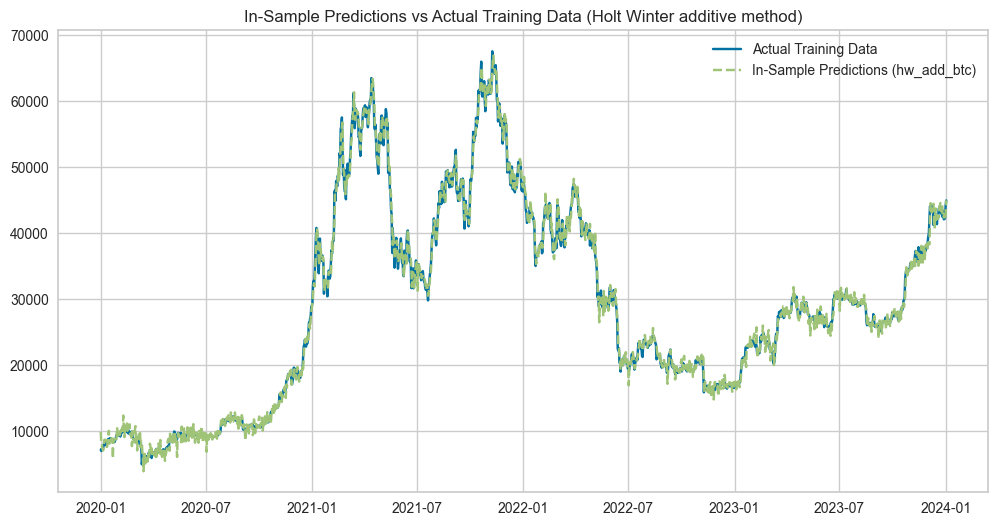

In [181]:
plt.figure(figsize=(12, 6))
actual_train_index_dt = exp_btc.get_config('y_train').index.to_timestamp()
prediction_index_dt = in_sample_predictions_hw_add_btc.index.to_timestamp()
plt.plot(actual_train_index_dt, exp_btc.get_config('y_train'), label='Actual Training Data')
plt.plot(prediction_index_dt, in_sample_predictions_hw_add_btc, label='In-Sample Predictions (hw_add_btc)', linestyle='--')
plt.title('In-Sample Predictions vs Actual Training Data (Holt Winter additive method)')
plt.legend()
plt.show()

Acquiring residuals

In [182]:
residuals = train_data_btc - in_sample_predictions_hw_add_btc
print("\nFirst 10 residuals:")
print(residuals.head(10))



First 10 residuals:
Date
2020-01-01   -2697.325906
2020-01-02    -985.626697
2020-01-03    -556.655587
2020-01-04      71.971390
2020-01-05     347.472660
2020-01-06     430.732963
2020-01-07    -486.751871
2020-01-08    -471.464461
2020-01-09    -851.707689
2020-01-10     287.745649
Freq: D, dtype: float64


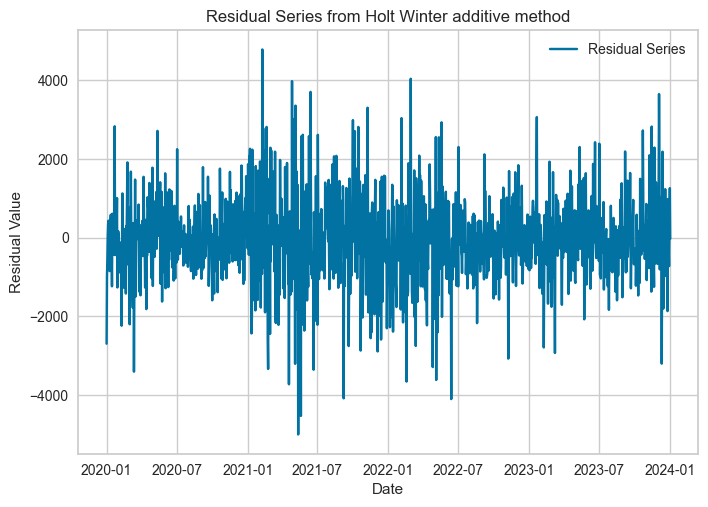

In [183]:
residuals_index_dt = residuals.index.to_timestamp()
plt.plot(residuals_index_dt, residuals, label='Residual Series')
plt.title('Residual Series from Holt Winter additive method')
plt.xlabel('Date')
plt.ylabel('Residual Value')
plt.legend()
plt.show()

Performing visualization of the acf  

In [184]:
exp_btc.plot_model(plot='acf',  data_kwargs={'nlags': 50}) 



Normalization

In [185]:
# Step 9: Normalized Residual Series (Min-Max Normalization)
scaler_residuals = MinMaxScaler(feature_range=(-1, 1))
normalized_residuals = scaler_residuals.fit_transform(residuals.values.reshape(-1, 1))
normalized_residuals = pd.Series(normalized_residuals.flatten(), index=residuals.index)

print("\nFirst 10 Normalized Residuals:")
print(normalized_residuals.head(10))


First 10 Normalized Residuals:
Date
2020-01-01   -0.528353
2020-01-02   -0.178737
2020-01-03   -0.091120
2020-01-04    0.037278
2020-01-05    0.093549
2020-01-06    0.110555
2020-01-07   -0.076842
2020-01-08   -0.073719
2020-01-09   -0.151384
2020-01-10    0.081350
Freq: D, dtype: float64


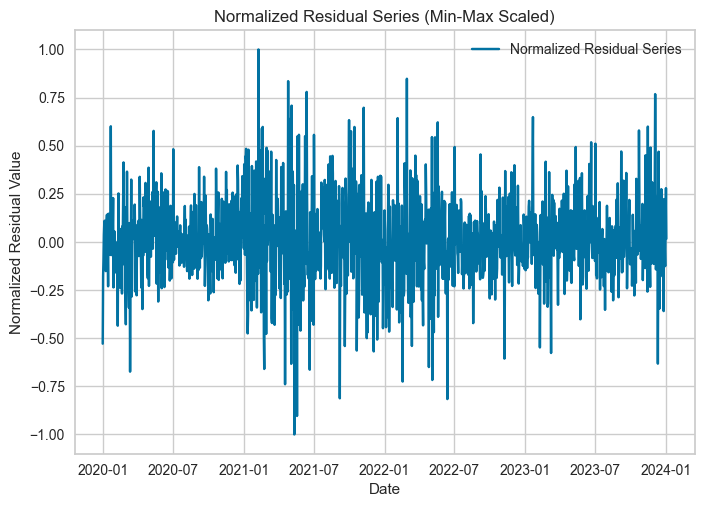

In [186]:
normalized_residuals_index_dt = normalized_residuals.index.to_timestamp()
plt.plot(normalized_residuals_index_dt, normalized_residuals, label='Normalized Residual Series')
plt.title('Normalized Residual Series (Min-Max Scaled)')
plt.xlabel('Date')
plt.ylabel('Normalized Residual Value')
plt.legend()
plt.show()


In [187]:
normalized_residuals.fillna(0, inplace=True) 

In [ ]:
# Step 10a: Preparing Data for ANN, Creating Lagged Features and Target

def create_lagged_features(series, lags):
    lagged_features = {}
    for lag in lags:
        lagged_features[f'lag_{lag}'] = series.shift(lag)
    lagged_df = pd.DataFrame(lagged_features)
    return lagged_df 

lags_to_use = [1, 7, 30] 

lagged_residual_features = create_lagged_features(normalized_residuals, lags_to_use)
lagged_residual_features.dropna(inplace=True) 

residual_target = normalized_residuals.reindex(lagged_residual_features.index)

X_train_ann = lagged_residual_features
y_train_ann = residual_target

X_train_ann_np = X_train_ann.values
y_train_ann_np = y_train_ann.values

In [ ]:
# The Data Splitting for Validation 
from sklearn.model_selection import train_test_split
X_train_ann_train, X_val_ann, y_train_ann_train, y_val_ann = train_test_split(
    X_train_ann, y_train_ann, test_size=0.2, shuffle=False
)

X_val_ann_np = X_val_ann.values  
y_val_ann_np = y_val_ann.values 
X_train_ann_train_np = X_train_ann_train.values 
y_train_ann_train_np = y_train_ann_train.values 

# Ensure that the Data Types are float32 
X_train_ann_train_np = X_train_ann_train_np.astype(np.float32) 
X_val_ann_np = X_val_ann_np.astype(np.float32) 
y_train_ann_train_np = y_train_ann_train_np.astype(np.float32) 
y_val_ann_np = y_val_ann_np.astype(np.float32)

In [190]:
# --- Manual Tuning Loop Code Block ---

neuron_options = [25, 50, 100]
epochs_options = [30, 50, 70]
batch_size_options = [16, 32, 64]

best_rmse = float('inf') 
best_params = None

for neurons in neuron_options:
    for epochs in epochs_options:
        for batch_size in batch_size_options:
            print(f"Trying: Neurons={neurons}, Epochs={epochs}, Batch Size={batch_size}")
            
            # Building an ANN model 
            ann_model = Sequential()
            ann_model.add(Dense(neurons, activation='relu', input_shape=(X_train_ann_train_np.shape[1],))) 
            ann_model.add(Dense(25, activation='relu'))
            ann_model.add(Dense(1))
            ann_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse') 
            
            # Train model
            ann_model.fit(X_train_ann_train_np, y_train_ann_train_np, epochs=epochs, batch_size=batch_size, verbose=0)
            
            print(f"NaNs in X_val_ann_np BEFORE prediction: {np.isnan(X_val_ann_np).any()}") 

            validation_predictions = ann_model.predict(X_val_ann_np).flatten() 
            rmse = np.sqrt(mean_squared_error(y_val_ann_np, validation_predictions)) 

            print(f"  Validation RMSE: {rmse:.4f}")

            if rmse < best_rmse: 
                best_rmse = rmse
                best_params = {'neurons': neurons, 'epochs': epochs, 'batch_size': batch_size}

print("\nBest Hyperparameters found (based on Validation RMSE):")
print(best_params)
print(f"Best Validation RMSE: {best_rmse:.4f}")

Trying: Neurons=25, Epochs=30, Batch Size=16
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 492us/step


  Validation RMSE: 0.0094
Trying: Neurons=25, Epochs=30, Batch Size=32
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 344us/step


  Validation RMSE: 0.0050
Trying: Neurons=25, Epochs=30, Batch Size=64
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 443us/step


  Validation RMSE: 0.0086
Trying: Neurons=25, Epochs=50, Batch Size=16
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 343us/step


  Validation RMSE: 0.0224
Trying: Neurons=25, Epochs=50, Batch Size=32
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 338us/step


  Validation RMSE: 0.0106
Trying: Neurons=25, Epochs=50, Batch Size=64
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 8ms/step


  Validation RMSE: 0.0080
Trying: Neurons=25, Epochs=70, Batch Size=16
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 483us/step


  Validation RMSE: 0.0119
Trying: Neurons=25, Epochs=70, Batch Size=32
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 359us/step


  Validation RMSE: 0.0460
Trying: Neurons=25, Epochs=70, Batch Size=64
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 415us/step


  Validation RMSE: 0.0099
Trying: Neurons=50, Epochs=30, Batch Size=16
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 363us/step


  Validation RMSE: 0.0091
Trying: Neurons=50, Epochs=30, Batch Size=32
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 400us/step


  Validation RMSE: 0.0225
Trying: Neurons=50, Epochs=30, Batch Size=64
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 347us/step


  Validation RMSE: 0.0068
Trying: Neurons=50, Epochs=50, Batch Size=16
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 366us/step


  Validation RMSE: 0.0196
Trying: Neurons=50, Epochs=50, Batch Size=32
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 337us/step


  Validation RMSE: 0.0078
Trying: Neurons=50, Epochs=50, Batch Size=64
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 394us/step


  Validation RMSE: 0.0164
Trying: Neurons=50, Epochs=70, Batch Size=16
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 422us/step


  Validation RMSE: 0.0206
Trying: Neurons=50, Epochs=70, Batch Size=32
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 343us/step


  Validation RMSE: 0.0195
Trying: Neurons=50, Epochs=70, Batch Size=64
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 385us/step


  Validation RMSE: 0.0249
Trying: Neurons=100, Epochs=30, Batch Size=16
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 439us/step


  Validation RMSE: 0.0272
Trying: Neurons=100, Epochs=30, Batch Size=32
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 340us/step


  Validation RMSE: 0.0092
Trying: Neurons=100, Epochs=30, Batch Size=64
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 347us/step


  Validation RMSE: 0.0083
Trying: Neurons=100, Epochs=50, Batch Size=16
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 471us/step


  Validation RMSE: 0.0146
Trying: Neurons=100, Epochs=50, Batch Size=32
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 342us/step


  Validation RMSE: 0.0105
Trying: Neurons=100, Epochs=50, Batch Size=64
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 366us/step


  Validation RMSE: 0.0180
Trying: Neurons=100, Epochs=70, Batch Size=16
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 1s 705us/step


  Validation RMSE: 0.0147
Trying: Neurons=100, Epochs=70, Batch Size=32
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 406us/step


  Validation RMSE: 0.0077
Trying: Neurons=100, Epochs=70, Batch Size=64
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 334us/step
  Validation RMSE: 0.0143

Best Hyperparameters found (based on Validation RMSE):
{'neurons': 25, 'epochs': 30, 'batch_size': 32}
Best Validation RMSE: 0.0050


In [205]:
# Best Hyperparameters from Tuning (replace with your best values if different)

best_neurons = 25
best_epochs = 30
best_batch_size = 32

# 1. Building the Final ANN Model with Best Hyperparameters
final_ann_model = Sequential()
final_ann_model.add(Dense(best_neurons, activation='relu', input_shape=(X_train_ann_np.shape[1],))) 1
final_ann_model.add(Dense(25, activation='relu')) 
final_ann_model.add(Dense(1))

# 2. Compiling the Final ANN Model
optimizer = Adam(learning_rate=0.001) 
final_ann_model.compile(optimizer=optimizer, loss='mse')

# 3. Training the Final ANN Model
final_ann_model.fit(X_train_ann_np, y_train_ann_np, epochs=best_epochs, batch_size=best_batch_size, verbose=0)

# 4. Print Model Summary of the Final Model
final_ann_model.summary()

print("\nFinal ANN Model Retraining Complete (with Best Hyperparameters)!")

Model: "sequential_686"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2058 (Dense)          (None, 25)                100       
                                                                 
 dense_2059 (Dense)          (None, 25)                650       
                                                                 
 dense_2060 (Dense)          (None, 1)                 26        
                                                                 
Total params: 776
Trainable params: 776
Non-trainable params: 0
_________________________________________________________________

Final ANN Model Retraining Complete (with Best Hyperparameters)!


Obtaining In-Sample ANN Residual Predictions


First 10 De-normalized In-Sample ANN Residual Predictions:
Date
2020-01-31    205.181061
2020-02-01    -81.575386
2020-02-02   -112.459579
2020-02-03   -192.634171
2020-02-04     31.510296
2020-02-05     56.315193
2020-02-06    -44.823742
2020-02-07   -156.927200
2020-02-08   -233.649063
2020-02-09    -41.709484
Freq: D, dtype: float32


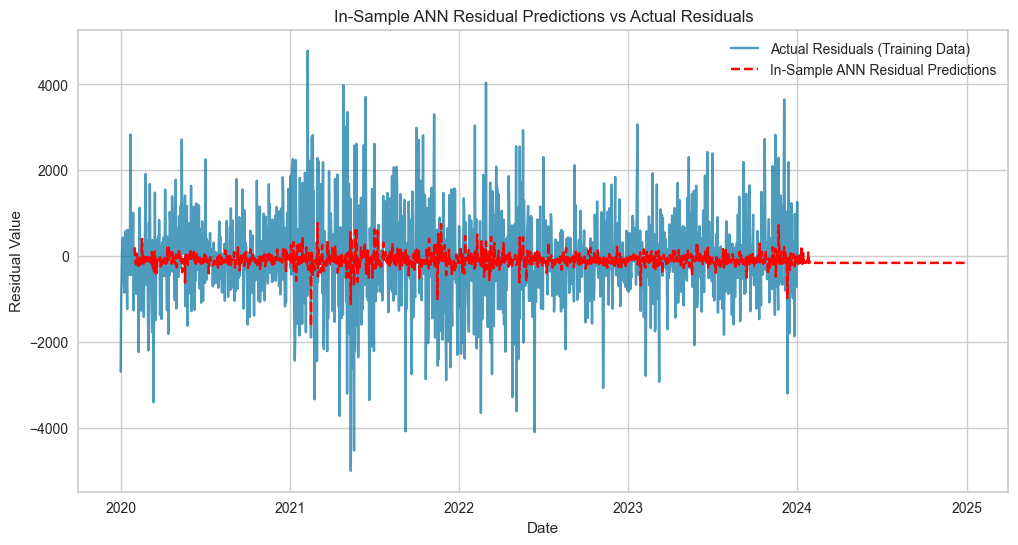

In [206]:
# 1. Generate In-Sample ANN Residual Predictions (Normalized)
ann_predictions_insample_normalized = final_ann_model.predict(X_train_ann_np, verbose=0).flatten()
ann_predictions_insample_normalized = pd.Series(ann_predictions_insample_normalized, index=X_train_ann.index)

# 2. De-normalize ANN Predictions (back to original residual scale)
ann_predictions_insample_denormalized = scaler_residuals.inverse_transform(ann_predictions_insample_normalized.values.reshape(-1, 1)).flatten()
ann_predictions_insample_denormalized = pd.Series(ann_predictions_insample_denormalized, index=ann_predictions_insample_normalized.index)

# 3. Print a sample of de-normalized in-sample ANN predictions
print("\nFirst 10 De-normalized In-Sample ANN Residual Predictions:")
print(ann_predictions_insample_denormalized.head(10))

# 4. Plotting In-Sample ANN Residual Predictions vs Actual Residuals 
plt.figure(figsize=(12, 6))
plt.plot(residuals.index.to_timestamp(), residuals, label='Actual Residuals (Training Data)', alpha=0.7) 
plt.plot(ann_predictions_insample_denormalized.index.to_timestamp(), ann_predictions_insample_denormalized, label='In-Sample ANN Residual Predictions', linestyle='--', color='red') 
plt.title('In-Sample ANN Residual Predictions vs Actual Residuals')
plt.xlabel('Date')
plt.ylabel('Residual Value')
plt.legend()
plt.show()

Obtaining Hold-out ANN Residual Predictions

In [209]:
# 1. Prepare for Iterative Forecast - Get last training residuals as initial history
last_train_residuals_normalized = normalized_residuals.tail(max(lags_to_use)).values 
ann_predictions_holdout_normalized = [] 
current_residuals_history = list(last_train_residuals_normalized) 

# 2. Iterative (Recursive) Forecast Loop - for each step in forecast horizon (fh)
forecast_horizon = len(exp_btc.get_config('y_test')) 

for _ in range(forecast_horizon): # Iterate for each step in forecast horizon
    
    # a. Feature vector from current residual history
    feature_vector = np.array([current_residuals_history[-lag] for lag in lags_to_use]).reshape(1, -1)
    
    # b. Predict next residual (normalized) using trained ANN model
    next_residual_normalized = final_ann_model.predict(feature_vector, verbose=0).flatten()[0] 
    ann_predictions_holdout_normalized.append(next_residual_normalized) 
    
    # c. Update residual history for next iteration - append predicted residual and remove oldest
    current_residuals_history.append(next_residual_normalized) 
    current_residuals_history.pop(0) 

# 3. Convert ANN Hold-out Predictions to Pandas Series with Test Set Index
ann_predictions_holdout_normalized = pd.Series(ann_predictions_holdout_normalized, index=exp_btc.get_config('y_test').index)

# 4. De-normalize ANN Hold-out Predictions 
ann_predictions_holdout_denormalized = scaler_residuals.inverse_transform(np.array(ann_predictions_holdout_normalized).reshape(-1, 1)).flatten()
ann_predictions_holdout_denormalized = pd.Series(ann_predictions_holdout_denormalized, index=ann_predictions_holdout_normalized.index)

# 5. Print sample of de-normalized hold-out ANN residual predictions
print("\nFirst 10 De-normalized Hold-out ANN Residual Predictions:")
print(ann_predictions_holdout_denormalized.head(10))

# Obtain ETS Hold-out Predictions
ets_predictions_holdout = exp_btc.predict_model(hw_add_btc)

# Ensuring the index of ETS hold-out predictions is a DatetimeIndex for plotting
if isinstance(ets_predictions_holdout.index, pd.PeriodIndex):
    ets_predictions_holdout.index = ets_predictions_holdout.index.to_timestamp()


First 10 De-normalized Hold-out ANN Residual Predictions:
Date
2024-01-03   -161.414856
2024-01-04   -167.918686
2024-01-05   -168.041794
2024-01-06   -168.061050
2024-01-07   -168.064056
2024-01-08   -168.064514
2024-01-09   -168.064606
2024-01-10   -159.746353
2024-01-11   -158.556503
2024-01-12   -158.517639
Freq: D, dtype: float32


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,Exponential Smoothing,4.6148,4.1232,10537.6225,14432.3696,0.1422,0.1590,0.0323


In [210]:
# Print summary statistics (min, max, mean, std) for actual test residuals
y_test_btc_datetime_index = y_test_btc.copy() # Created a copy to avoid modifying original y_test_btc
y_test_btc_datetime_index.index = y_test_btc_datetime_index.index.to_timestamp() 

actual_test_residuals_series = y_test_btc_datetime_index - ets_predictions_holdout['y_pred']

print("\nSummary Statistics - Actual Test Set Residuals (DatetimeIndex):")
print(actual_test_residuals_series.describe())

# Print summary statistics for de-normalized ANN hold-out predictions
print("\nSummary Statistics - De-normalized ANN Hold-out Predictions:")
print(ann_predictions_holdout_denormalized.describe())


Summary Statistics - Actual Test Set Residuals (DatetimeIndex):
count      365.000000
mean      9516.602711
std      10865.127401
min      -7100.725694
25%       1531.205356
50%       7142.257125
75%      15481.524962
max      41474.786950
dtype: float64

Summary Statistics - De-normalized ANN Hold-out Predictions:
count    365.000000
mean    -156.932571
std        1.652733
min     -168.064606
25%     -156.577164
50%     -156.577164
75%     -156.577164
max     -155.075226
dtype: float64


In [211]:
print("\nHead of ets_predictions_holdout DataFrame:")
print(ets_predictions_holdout.head())
print("\nInfo of ets_predictions_holdout DataFrame:")
ets_predictions_holdout.info()


Head of ets_predictions_holdout DataFrame:
                y_pred
2024-01-03  44924.2809
2024-01-04  44574.1519
2024-01-05  44509.0693
2024-01-06  45401.2621
2024-01-07  45762.9775

Info of ets_predictions_holdout DataFrame:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2024-01-03 to 2025-01-01
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y_pred  365 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


In [212]:
print("\nHead of y_test_btc DataFrame:")
print(y_test_btc.head())
print("\nInfo of y_test_btc DataFrame:")
y_test_btc.info()



Head of y_test_btc DataFrame:
Date
2024-01-03    42848.175781
2024-01-04    44179.921875
2024-01-05    44162.691406
2024-01-06    43989.195312
2024-01-07    43943.097656
Freq: D, Name: Close, dtype: float64

Info of y_test_btc DataFrame:
<class 'pandas.core.series.Series'>
PeriodIndex: 365 entries, 2024-01-03 to 2025-01-01
Freq: D
Series name: Close
Non-Null Count  Dtype  
--------------  -----  
365 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


In [213]:
# Re-run to obtain Hold-out (Test Set) Predictions from Best ETS Model
ets_predictions_holdout = exp_btc.predict_model(hw_add_btc) 

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,Exponential Smoothing,4.6148,4.1232,10537.6225,14432.3696,0.1422,0.1590,0.0323


In [214]:
print("Test Data BTC Head:")
print(test_data_btc.head())

print("\nETS Predictions Holdout Head:")
print(ets_predictions_holdout.head())

Test Data BTC Head:
Date
2025-01-01    94419.757812
Freq: D, Name: Close, dtype: float64

ETS Predictions Holdout Head:
                y_pred
2024-01-03  44924.2809
2024-01-04  44574.1519
2024-01-05  44509.0693
2024-01-06  45401.2621
2024-01-07  45762.9775


In [215]:
# Calculate residuals: actual - predictions


residuals = train_data_btc - in_sample_predictions_hw_add_btc 


Combine ETS and ANN Predictions for Final Hybrid Forecasts

In [216]:
# Get ETS hold-out predictions 
ets_predictions_holdout = exp_btc.predict_model(hw_add_btc)

# Combine ETS predictions and ANN residual predictions for final hybrid hold-out forecasts
final_predictions_holdout_hybrid = ets_predictions_holdout['y_pred'] + ann_predictions_holdout_denormalized

# Print the first few final hybrid hold-out forecasts
print("\nFirst 10 Final Hybrid Hold-out Forecasts:")
print(final_predictions_holdout_hybrid.head(10))

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,Exponential Smoothing,4.6148,4.1232,10537.6225,14432.3696,0.1422,0.1590,0.0323



First 10 Final Hybrid Hold-out Forecasts:
2024-01-03    44762.866044
2024-01-04    44406.233214
2024-01-05    44341.027506
2024-01-06    45233.201050
2024-01-07    45594.913444
2024-01-08    46220.532286
2024-01-09    46179.860894
2024-01-10    45654.277447
2024-01-11    45239.185897
2024-01-12    45452.100361
Freq: D, dtype: float64


In [218]:
def ts_metrics(y, y_hat):
   
    mae = mean_absolute_error(y, y_hat)
    mape = mean_absolute_percentage_error(y, y_hat)
    rmse = np.sqrt(mean_squared_error(y, y_hat))
    r2 = r2_score(y, y_hat)
    
    metrics = {
        'MAE': mae,
        'MAPE': mape,
        'RMSE': rmse,
        'R2': r2,
    }
    
    # Print metrics with descriptions
    print("Time Series Model Evaluation Metrics:")
    print("-" * 40)
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.4%}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R-squared (R²): {r2:.4f}")
    
    return 

Evaluate Hybrid Model Performance on Hold-out Set

In [219]:
print("\n--- Hybrid Model Evaluation Metrics (Hold-out Set) ---")
ts_metrics(exp_btc.get_config('y_test'), final_predictions_holdout_hybrid) 


--- Hybrid Model Evaluation Metrics (Hold-out Set) ---
Time Series Model Evaluation Metrics:
----------------------------------------
Mean Absolute Error (MAE): 10638.1669
Mean Absolute Percentage Error (MAPE): 14.3456%
Root Mean Squared Error (RMSE): 14536.0528
R-squared (R²): 0.0184


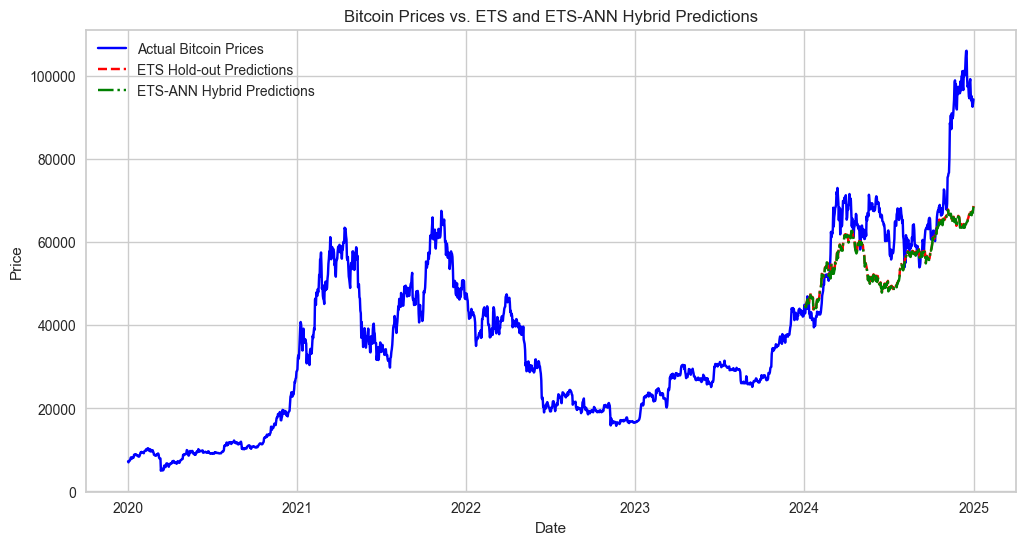

In [220]:
# Ensure correct index type for plotting
if isinstance(df_BTC.index, pd.PeriodIndex):
    df_BTC.index = df_BTC.index.to_timestamp()

if isinstance(ets_predictions_holdout.index, pd.PeriodIndex):
    ets_predictions_holdout.index = ets_predictions_holdout.index.to_timestamp()

# Ensure df_BTC is a DataFrame and contains the 'Close' column
if isinstance(df_BTC, pd.Series):
    df_BTC = df_BTC.to_frame(name='Close')

plt.figure(figsize=(12, 6))

# Plot Actual Bitcoin Prices (Full Data)
if isinstance(df_BTC, pd.DataFrame) and 'Close' in df_BTC.columns:
    plt.plot(df_BTC.index, df_BTC['Close'], label='Actual Bitcoin Prices', color='blue')
else:
    print("Error: 'Close' column not found in df_BTC DataFrame")

# Plot ETS Hold-out Predictions
if isinstance(ets_predictions_holdout, pd.DataFrame) and 'y_pred' in ets_predictions_holdout.columns:
    plt.plot(ets_predictions_holdout.index, ets_predictions_holdout['y_pred'], label='ETS Hold-out Predictions', color='red', linestyle='--')
else:
    print("Error: 'y_pred' column not found in ets_predictions_holdout DataFrame")

# Plot ETS-ANN Hybrid Predictions
if isinstance(final_predictions_holdout_hybrid, pd.Series):
    plt.plot(final_predictions_holdout_hybrid.index, final_predictions_holdout_hybrid, label='ETS-ANN Hybrid Predictions', color='green', linestyle='-.')
else:
    print("Error: final_predictions_holdout_hybrid is not a Series")

plt.title('Bitcoin Prices vs. ETS and ETS-ANN Hybrid Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

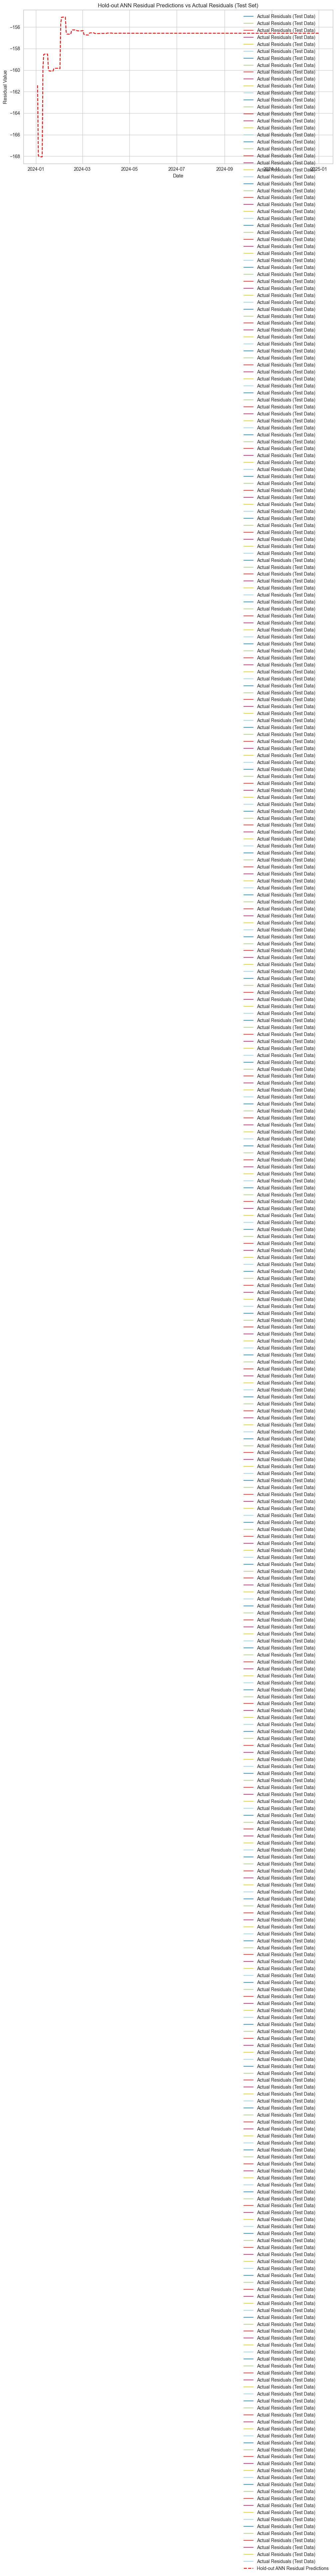

In [ ]:
# 6. Plotting Hold-out ANN Residual Predictions vs Actual Residuals
plt.figure(figsize=(12, 6))
plt.plot(exp_btc.get_config('y_test').index.to_timestamp(), exp_btc.get_config('y_test') - ets_predictions_holdout, label='Actual Residuals (Test Data)', alpha=0.7) # Actual test residuals (calculated)
plt.plot(ann_predictions_holdout_denormalized.index.to_timestamp(), ann_predictions_holdout_denormalized, label='Hold-out ANN Residual Predictions', linestyle='--', color='red') # ANN holdout predictions
plt.title('Hold-out ANN Residual Predictions vs Actual Residuals (Test Set)')
plt.xlabel('Date')
plt.ylabel('Residual Value')
plt.legend()
plt.show()

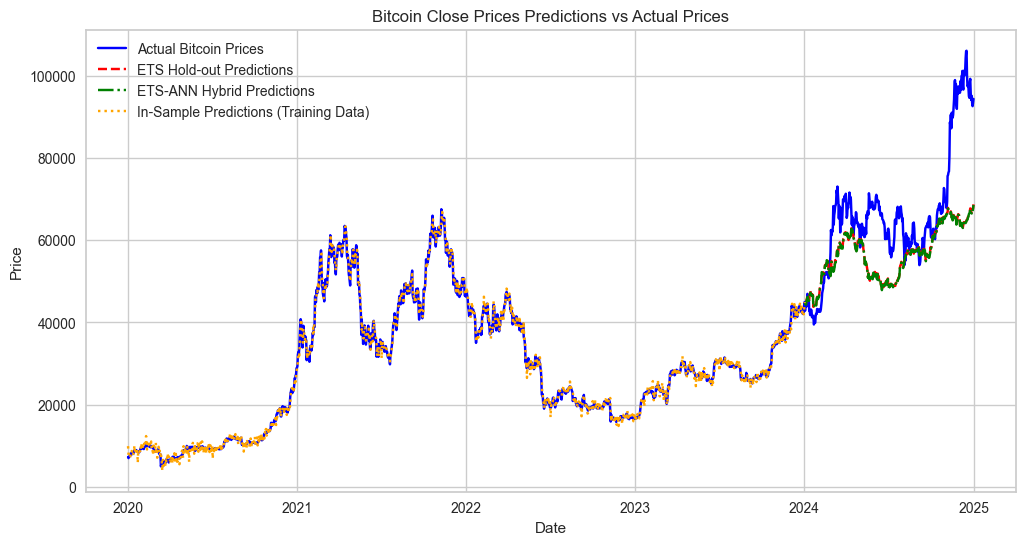

In [224]:
# Ensure correct index type for plotting
if isinstance(df_BTC.index, pd.PeriodIndex):
    df_BTC.index = df_BTC.index.to_timestamp()

if isinstance(ets_predictions_holdout.index, pd.PeriodIndex):
    ets_predictions_holdout.index = ets_predictions_holdout.index.to_timestamp()

# Ensure df_BTC is a DataFrame and contains the 'Close' column
if isinstance(df_BTC, pd.Series):
    df_BTC = df_BTC.to_frame(name='Close')

plt.figure(figsize=(12, 6))

# Plot Actual Bitcoin Prices (Full Data)
if isinstance(df_BTC, pd.DataFrame) and 'Close' in df_BTC.columns:
    plt.plot(df_BTC.index, df_BTC['Close'], label='Actual Bitcoin Prices', color='blue')
else:
    print("Error: 'Close' column not found in df_BTC DataFrame")

# Plot ETS Hold-out Predictions
if isinstance(ets_predictions_holdout, pd.DataFrame) and 'y_pred' in ets_predictions_holdout.columns:
    plt.plot(ets_predictions_holdout.index, ets_predictions_holdout['y_pred'], label='ETS Hold-out Predictions', color='red', linestyle='--')
else:
    print("Error: 'y_pred' column not found in ets_predictions_holdout DataFrame")

# Plot ETS-ANN Hybrid Predictions
if isinstance(final_predictions_holdout_hybrid, pd.Series):
    plt.plot(final_predictions_holdout_hybrid.index, final_predictions_holdout_hybrid, label='ETS-ANN Hybrid Predictions', color='green', linestyle='-.')
else:
    print("Error: final_predictions_holdout_hybrid is not a Series")

# Plot In-Sample Predictions (Training Data)
if isinstance(in_sample_predictions_hw_add_btc, pd.Series):
    plt.plot(in_sample_predictions_hw_add_btc.index.to_timestamp(), in_sample_predictions_hw_add_btc, label='In-Sample Predictions (Training Data)', color='orange', linestyle=':')
else:
    print("Error: in_sample_predictions_hw_add_btc is not a Series")

plt.title('Bitcoin Close Prices Predictions vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [225]:
# Show counts and date ranges for training, validation (if applicable), and test sets

# Training set
train_start_date = df_BTC.index[0]
train_end_date = df_BTC.index[len(y_train_btc) - 1]
train_count = len(y_train_btc)

# Test set
test_start_date = df_BTC.index[len(y_train_btc)]
test_end_date = df_BTC.index[len(df_BTC) - 1]
test_count = len(y_test_btc)

print(f"Training Set: {train_count} data points from {train_start_date} to {train_end_date}")
print(f"Test Set: {test_count} data points from {test_start_date} to {test_end_date}")

# If you have a validation set, include the following code

# Validation set (if used)
try:
    val_start_date = df_BTC.index[len(y_train_btc) - 60]
    val_end_date = df_BTC.index[len(y_train_btc) + len(y_val_ann) - 61]
    val_count = len(y_val_ann)

    print(f"Validation Set: {val_count} data points from {val_start_date} to {val_end_date}")
except NameError:
    print("No explicit validation set used in this script.")

Training Set: 1463 data points from 2020-01-01 00:00:00 to 2024-01-02 00:00:00
Test Set: 365 data points from 2024-01-03 00:00:00 to 2025-01-01 00:00:00
Validation Set: 360 data points from 2023-11-04 00:00:00 to 2024-10-28 00:00:00
